# 表达谱基本分析及查询

> 日期：2022-12-7
>
> 实验者：生信 2001 张子栋
>
> [MarkdownNotes/软件第7次作业.md at main · Bluuur/MarkdownNotes (github.com)](https://github.com/Bluuur/MarkdownNotes/blob/main/生物信息学原理/软件第7次作业.md)
> [生物信息学原理/软件第7次作业.md · blur/MarkdownNotes - 码云 - 开源中国 (gitee.com)](https://gitee.com/bluur/MarkdownNotes/blob/main/生物信息学原理/软件第7次作业.md)

## 实验目的

1. 熟悉表达谱数据库的查询和数据下载
2. 熟悉芯片表达谱数据分析的一般流程
3. 掌握表达差异分析和基因富集分析的方法
4. 了解常用的数据可视化方法

## 实验内容

1. GEO 数据库查询和数据下载
2. 使用 R 包 `limma` 进行差异表达分析
3. 使用 R 包 `clusterProfiler` 进行基因富集分析
4. 使用 `gplots`, `ggpubr`, `pheatmap` 等 R 包对差异表达和富集分析进行结果可视化

## 实验步骤

以 `GSE46456` 为例，该实验使用的芯片平台为 GPL198，拟南芥样本基因型包括：野生型、BRI1 单突变型、GUL2 单突变型、BRI 和 GUL 双突变型，每种基因型设置**三种重复**。研究三种突变型样本与 WT 野生型样本哪些基因存在显著的差异表达。根据所提供的演示代码和相关文件，请完成以下任务：

1. 对获得的芯片数据进行数据标准化、探针过滤、limma 差异分析，写明每一步骤的代码、目的以及中间结果。

加载 R 包

In [1]:
library(cluster)
library(kohonen)
library(gplots)
library(RankProd)
library(affy)
library(affyPLM)
library(RColorBrewer)
library(limma)
library(pheatmap)
library(Mfuzz)
library(clusterProfiler)
library(enrichplot)
library(ggplot2)
library("org.At.tair.db", character.only = TRUE)

Warning message:
"程辑包'cluster'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'kohonen'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'gplots'是用R版本4.1.3 来建造的"

载入程辑包：'gplots'


The following object is masked from 'package:stats':

    lowess


载入需要的程辑包：Rmpfr

Warning message:
"程辑包'Rmpfr'是用R版本4.1.3 来建造的"
载入需要的程辑包：gmp

Warning message:
"程辑包'gmp'是用R版本4.1.3 来建造的"

载入程辑包：'gmp'


The following objects are masked from 'package:base':

    %*%, apply, crossprod, matrix, tcrossprod


C code of R package 'Rmpfr': GMP using 64 bits per limb



载入程辑包：'Rmpfr'


The following object is masked from 'package:gmp':

    outer


The following objects are masked from 'package:stats':

    dbinom, dgamma, dnbinom, dnorm, dpois, dt, pnorm


The following objects are masked from 'package:base':

    cbind, pmax, pmin, rbind


载入需要的程辑包：BiocGenerics

载入需要的程辑包：parallel


载入程辑包：'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport

读取数据并标准化

In [2]:
# 生成文件列表以便批量导入文件
cels <- list.files("C:\\Users\\ZidongZh\\Documents\\BioInf\\GSE46456_RAW", pattern = "*.gz", full.names = TRUE)
# 使用 Affy 包中 ReadAffy 函数，读取 CEL 文件，将其处理成 AffyBatch 对象
celfiles <- ReadAffy(filenames = cels)
# 将 AffyBatch 对象转换为 ExpressionSet 对象，对数据进行标准化
celfiles.rma <- rma(celfiles)
cols <- brewer.pal(8, "Set1")

Warning message:
"replacing previous import 'AnnotationDbi::tail' by 'utils::tail' when loading 'ath1121501cdf'"
Warning message:
"replacing previous import 'AnnotationDbi::head' by 'utils::head' when loading 'ath1121501cdf'"




Background correcting
Normalizing
Calculating Expression


In [ ]:
setwd("C:\\Users\\ZidongZh\\Documents\\BioInf\\GSE46456_RAW")
# 未标准化的数据
boxplot(celfiles, col=cols)
# 标准化的数据
boxplot(celfiles.rma, col=cols)

密度和对数强度直方图

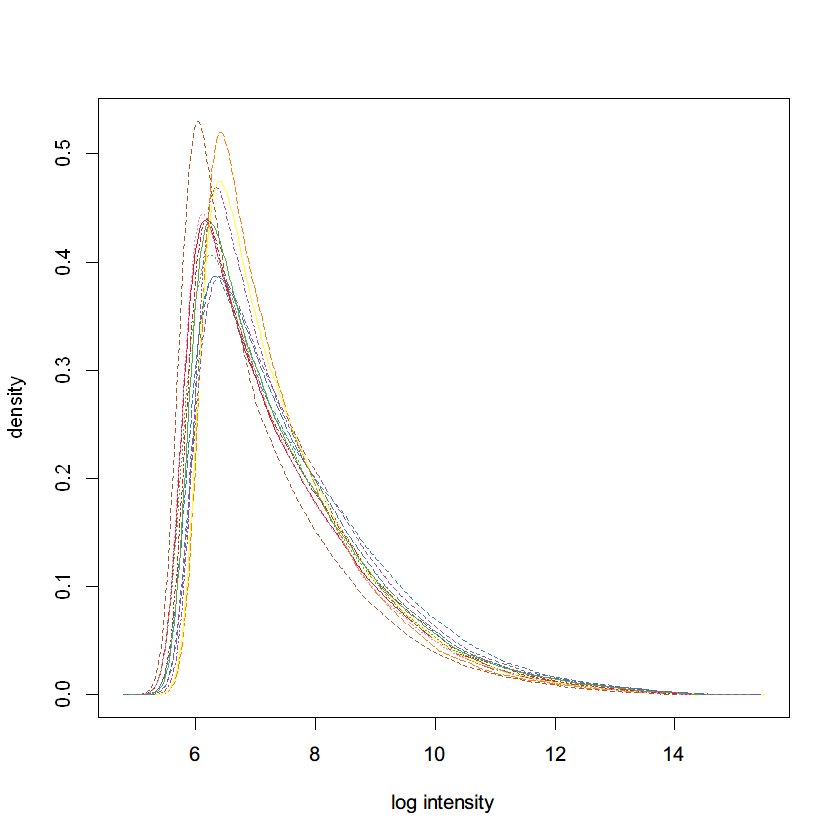

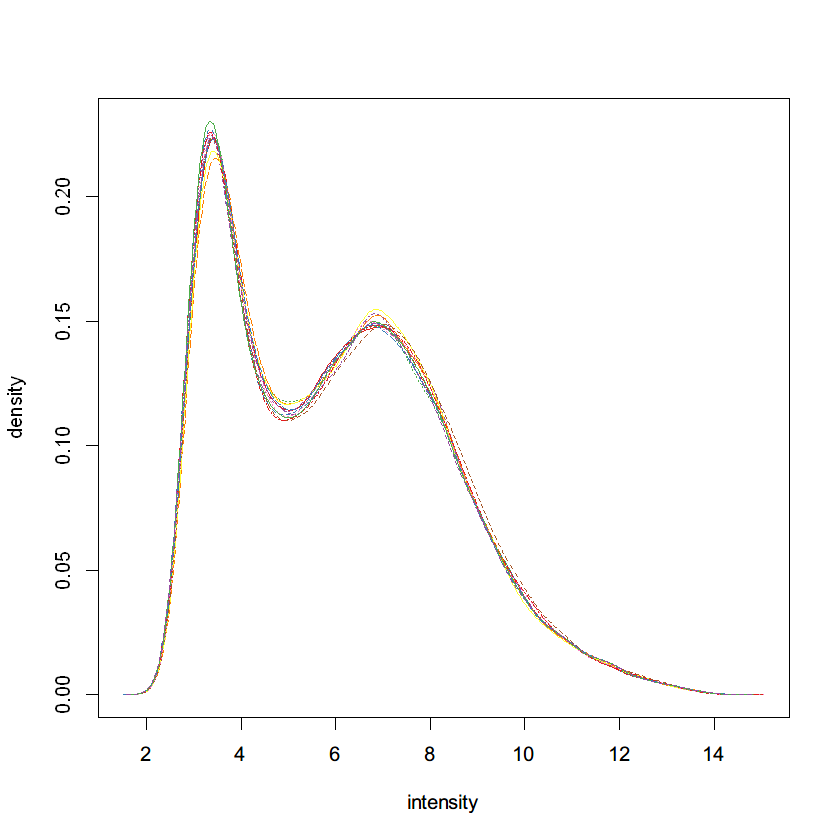

In [4]:
# 未标准化的数据
hist(celfiles, col = cols)
# 标准化的数据
hist(celfiles.rma, col = cols)

探针过滤

In [5]:
# list 中的 eset 为过滤后的 ExpressionSet, filter.log 为每一步过滤到多少探针的记录。
library(genefilter)
celfiles.filtered <- nsFilter(celfiles.rma, require.entrez=FALSE, remove.dupEntrez=FALSE)

In [6]:
celfiles.filtered$filter.log
celfiles.filtered$eset

$numLowVar
[1] 11373

$feature.exclude
[1] 64

ExpressionSet (storageMode: lockedEnvironment)
assayData: 11373 features, 12 samples 
  element names: exprs 
protocolData
  sampleNames: GSM1130596_Ws-2-1.CEL.gz GSM1130597_Ws-2-2.CEL.gz ...
    GSM1130607_gul2-1bri1-5-3.CEL.gz (12 total)
  varLabels: ScanDate
  varMetadata: labelDescription
phenoData
  sampleNames: GSM1130596_Ws-2-1.CEL.gz GSM1130597_Ws-2-2.CEL.gz ...
    GSM1130607_gul2-1bri1-5-3.CEL.gz (12 total)
  varLabels: sample
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation: ath1121501 

获得表达量矩阵

In [7]:
eset <- exprs(celfiles.filtered$eset)
head(eset)

,GSM1130596_Ws-2-1.CEL.gz,GSM1130597_Ws-2-2.CEL.gz,GSM1130598_Ws-2-3.CEL.gz,GSM1130599_bri1-5-1.CEL.gz,GSM1130600_bri1-5-2.CEL.gz,GSM1130601_bri1-5-3.CEL.gz,GSM1130602_gul2-1-1.CEL.gz,GSM1130603_gul2-1-2.CEL.gz,GSM1130604_gul2-1-3.CEL.gz,GSM1130605_gul2-1bri1-5-1.CEL.gz,GSM1130606_gul2-1bri1-5-2.CEL.gz,GSM1130607_gul2-1bri1-5-3.CEL.gz
244901_at,5.224648,5.428151,5.546510,4.683135,4.753393,4.463033,6.087000,5.868863,5.386404,5.490967,5.671008,5.305481
244902_at,5.149407,5.187442,4.886097,4.672779,4.805556,4.794880,5.527636,5.592619,5.927320,5.302640,5.524203,5.494279
244903_at,5.592680,5.436074,5.638751,5.562216,5.622267,5.224591,6.605356,6.062327,5.597098,6.694592,6.661931,6.565135
244904_at,4.985820,5.072172,5.262937,5.016912,5.446725,5.482161,5.366306,5.495490,5.026725,5.257816,5.356717,5.228070
244906_at,5.727308,5.889640,5.323069,5.381804,5.609199,5.514687,6.348055,6.080350,6.218219,6.613726,6.537190,6.425924
244912_at,6.465566,6.586064,6.814510,7.653073,7.871753,8.260488,8.052288,7.970124,7.871955,7.620157,7.387385,7.555005


增加探针对应的基因信息

In [8]:
araAnno <- read.delim("C:\\Users\\ZidongZh\\Documents\\BioInf\\affy_ATH1_array_elements-2010-12-20.txt")
head(araAnno)
head(eset)
ids <- match(rownames(eset), araAnno$array_element_name)
length(araAnno$array_element_name)
length(ids)
# ids
head(eset)
rownames(eset) <- araAnno$locus[ids]
colnames(eset) <- sub(".CEL.gz", "", colnames(eset))
head(eset)

,array_element_name,array_element_type,organism,is_control,locus,description,chromosome,start,stop
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,244901_at,oligonucleotide,Arabidopsis thaliana,no,ATMG00640,"hydrogen ion transporting ATP synthases, rotational mechanism;zinc ion binding",M,188160,188619
2,244902_at,oligonucleotide,Arabidopsis thaliana,no,ATMG00650,NADH dehydrogenase subunit 4L,M,188954,189182
3,244903_at,oligonucleotide,Arabidopsis thaliana,no,ATMG00660,hypothetical protein,M,190106,190540
4,244904_at,oligonucleotide,Arabidopsis thaliana,no,ATMG00670,hypothetical protein,M,191055,191627
5,244905_at,oligonucleotide,Arabidopsis thaliana,no,ATMG00680,hypothetical protein,M,201768,202096
6,244906_at,oligonucleotide,Arabidopsis thaliana,no,ATMG00690,hypothetical protein,M,203634,204043


,GSM1130596_Ws-2-1.CEL.gz,GSM1130597_Ws-2-2.CEL.gz,GSM1130598_Ws-2-3.CEL.gz,GSM1130599_bri1-5-1.CEL.gz,GSM1130600_bri1-5-2.CEL.gz,GSM1130601_bri1-5-3.CEL.gz,GSM1130602_gul2-1-1.CEL.gz,GSM1130603_gul2-1-2.CEL.gz,GSM1130604_gul2-1-3.CEL.gz,GSM1130605_gul2-1bri1-5-1.CEL.gz,GSM1130606_gul2-1bri1-5-2.CEL.gz,GSM1130607_gul2-1bri1-5-3.CEL.gz
244901_at,5.224648,5.428151,5.546510,4.683135,4.753393,4.463033,6.087000,5.868863,5.386404,5.490967,5.671008,5.305481
244902_at,5.149407,5.187442,4.886097,4.672779,4.805556,4.794880,5.527636,5.592619,5.927320,5.302640,5.524203,5.494279
244903_at,5.592680,5.436074,5.638751,5.562216,5.622267,5.224591,6.605356,6.062327,5.597098,6.694592,6.661931,6.565135
244904_at,4.985820,5.072172,5.262937,5.016912,5.446725,5.482161,5.366306,5.495490,5.026725,5.257816,5.356717,5.228070
244906_at,5.727308,5.889640,5.323069,5.381804,5.609199,5.514687,6.348055,6.080350,6.218219,6.613726,6.537190,6.425924
244912_at,6.465566,6.586064,6.814510,7.653073,7.871753,8.260488,8.052288,7.970124,7.871955,7.620157,7.387385,7.555005


[1] 22810

[1] 11373

,GSM1130596_Ws-2-1.CEL.gz,GSM1130597_Ws-2-2.CEL.gz,GSM1130598_Ws-2-3.CEL.gz,GSM1130599_bri1-5-1.CEL.gz,GSM1130600_bri1-5-2.CEL.gz,GSM1130601_bri1-5-3.CEL.gz,GSM1130602_gul2-1-1.CEL.gz,GSM1130603_gul2-1-2.CEL.gz,GSM1130604_gul2-1-3.CEL.gz,GSM1130605_gul2-1bri1-5-1.CEL.gz,GSM1130606_gul2-1bri1-5-2.CEL.gz,GSM1130607_gul2-1bri1-5-3.CEL.gz
244901_at,5.224648,5.428151,5.546510,4.683135,4.753393,4.463033,6.087000,5.868863,5.386404,5.490967,5.671008,5.305481
244902_at,5.149407,5.187442,4.886097,4.672779,4.805556,4.794880,5.527636,5.592619,5.927320,5.302640,5.524203,5.494279
244903_at,5.592680,5.436074,5.638751,5.562216,5.622267,5.224591,6.605356,6.062327,5.597098,6.694592,6.661931,6.565135
244904_at,4.985820,5.072172,5.262937,5.016912,5.446725,5.482161,5.366306,5.495490,5.026725,5.257816,5.356717,5.228070
244906_at,5.727308,5.889640,5.323069,5.381804,5.609199,5.514687,6.348055,6.080350,6.218219,6.613726,6.537190,6.425924
244912_at,6.465566,6.586064,6.814510,7.653073,7.871753,8.260488,8.052288,7.970124,7.871955,7.620157,7.387385,7.555005


,GSM1130596_Ws-2-1,GSM1130597_Ws-2-2,GSM1130598_Ws-2-3,GSM1130599_bri1-5-1,GSM1130600_bri1-5-2,GSM1130601_bri1-5-3,GSM1130602_gul2-1-1,GSM1130603_gul2-1-2,GSM1130604_gul2-1-3,GSM1130605_gul2-1bri1-5-1,GSM1130606_gul2-1bri1-5-2,GSM1130607_gul2-1bri1-5-3
ATMG00640,5.224648,5.428151,5.546510,4.683135,4.753393,4.463033,6.087000,5.868863,5.386404,5.490967,5.671008,5.305481
ATMG00650,5.149407,5.187442,4.886097,4.672779,4.805556,4.794880,5.527636,5.592619,5.927320,5.302640,5.524203,5.494279
ATMG00660,5.592680,5.436074,5.638751,5.562216,5.622267,5.224591,6.605356,6.062327,5.597098,6.694592,6.661931,6.565135
ATMG00670,4.985820,5.072172,5.262937,5.016912,5.446725,5.482161,5.366306,5.495490,5.026725,5.257816,5.356717,5.228070
ATMG00690,5.727308,5.889640,5.323069,5.381804,5.609199,5.514687,6.348055,6.080350,6.218219,6.613726,6.537190,6.425924
AT2G07783;ATMG00830,6.465566,6.586064,6.814510,7.653073,7.871753,8.260488,8.052288,7.970124,7.871955,7.620157,7.387385,7.555005


3. 运用 `limma` 获得突变体和野生型的差异表达基因集，并阐述差异分析结果的各列含义。

分组矩阵

In [9]:
group_list <- c(rep('Wild_type', 3),
                rep('bri1.5_mutant', 3),
                rep('gul2.1_mutant', 3),
                rep('gul2.1_bri1.5_mutant',3))
design <- model.matrix(~0+factor(group_list))
colnames(design) <- levels(factor(group_list))
rownames(design) <- colnames(eset)
design

,bri1.5_mutant,gul2.1_bri1.5_mutant,gul2.1_mutant,Wild_type
GSM1130596_Ws-2-1,0,0,0,1
GSM1130597_Ws-2-2,0,0,0,1
GSM1130598_Ws-2-3,0,0,0,1
GSM1130599_bri1-5-1,1,0,0,0
GSM1130600_bri1-5-2,1,0,0,0
GSM1130601_bri1-5-3,1,0,0,0
GSM1130602_gul2-1-1,0,0,1,0
GSM1130603_gul2-1-2,0,0,1,0
GSM1130604_gul2-1-3,0,0,1,0
GSM1130605_gul2-1bri1-5-1,0,1,0,0


构建对照矩阵

In [10]:
contrast.matrix <- makeContrasts(bri1.5_mutant-Wild_type,
                                 gul2.1_mutant-Wild_type,
                                 gul2.1_bri1.5_mutant-Wild_type,
                                 levels = design)
contrast.matrix

,bri1.5_mutant - Wild_type,gul2.1_mutant - Wild_type,gul2.1_bri1.5_mutant - Wild_type
bri1.5_mutant,1,0,0
gul2.1_bri1.5_mutant,0,0,1
gul2.1_mutant,0,1,0
Wild_type,-1,-1,-1


拟合 差值计算 检验

In [11]:
# limma
# 线性模型拟合
fit1 <- lmFit(eset, design)
# 根据对比模型进行差值计算
fit2 <- contrasts.fit(fit1, contrast.matrix)
# 贝叶斯检验
fit2 <- eBayes(fit2)

输出差异表达基因

In [14]:
# 利用 toptable 导出 DEG 结果
limma_results <- lapply(colnames(contrast.matrix),
                        function(x) {
                          topTable(fit2,
                                   coef     = x,
                                   adjust   = "fdr",
                                   sort.by  = "logFC",
                                   number   = Inf)
                        })
length(limma_results)
# 对导出的结果标记 title 信息
names(limma_results) <- colnames(contrast.matrix)
head(limma_results[[1]])
save(limma_results, file = "limma_compare_res.RData")
# 对每对比较的样本对 DEG 结果单独导出 DEG 信息 6
for (n in names(limma_results)) {
    write.table(limma_results[[n]],
                file        = sprintf("%s.tsv", gsub(' ', '', n)),
                row.names   = FALSE,
                sep         = "\t")
}
save(eset, file = "eset.RData")
head(eset)

[1] 3

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
311,AT4G15620,4.414308,5.380715,35.58470,2.706107e-19,1.538828e-15,33.49616
46,ATCG00790,4.022998,10.302096,35.58878,2.700114e-19,1.538828e-15,33.49803
1693,AT5G53870,-3.405975,6.478671,-20.55259,9.726000e-15,7.374253e-12,23.92538
742,AT1G57750,-3.346731,5.462349,-29.17670,1.241947e-17,3.531167e-14,30.16103
45,ATCG00780,3.195997,8.690368,21.39171,4.579686e-15,4.539751e-12,24.65109
21,ATCG00065,3.039406,7.137484,22.37312,1.963188e-15,2.480816e-12,25.46182


,GSM1130596_Ws-2-1,GSM1130597_Ws-2-2,GSM1130598_Ws-2-3,GSM1130599_bri1-5-1,GSM1130600_bri1-5-2,GSM1130601_bri1-5-3,GSM1130602_gul2-1-1,GSM1130603_gul2-1-2,GSM1130604_gul2-1-3,GSM1130605_gul2-1bri1-5-1,GSM1130606_gul2-1bri1-5-2,GSM1130607_gul2-1bri1-5-3
ATMG00640,5.224648,5.428151,5.546510,4.683135,4.753393,4.463033,6.087000,5.868863,5.386404,5.490967,5.671008,5.305481
ATMG00650,5.149407,5.187442,4.886097,4.672779,4.805556,4.794880,5.527636,5.592619,5.927320,5.302640,5.524203,5.494279
ATMG00660,5.592680,5.436074,5.638751,5.562216,5.622267,5.224591,6.605356,6.062327,5.597098,6.694592,6.661931,6.565135
ATMG00670,4.985820,5.072172,5.262937,5.016912,5.446725,5.482161,5.366306,5.495490,5.026725,5.257816,5.356717,5.228070
ATMG00690,5.727308,5.889640,5.323069,5.381804,5.609199,5.514687,6.348055,6.080350,6.218219,6.613726,6.537190,6.425924
AT2G07783;ATMG00830,6.465566,6.586064,6.814510,7.653073,7.871753,8.260488,8.052288,7.970124,7.871955,7.620157,7.387385,7.555005


+ `ID`: Gene ID
+ `logFC`: 两组表达值之间以2为底对数化的变化倍数（Fold change, FC），由于基因表达矩阵本身已经取了对数，这里实际上只是两组基因表达值均值之差。
+ `AveExpr`: 该探针组所在所有样品中的平均表达值。
+ `t`：贝叶斯调整后的两组表达值间 $T$ 检验中的 $t$ 统计量。
+ `P.Value`: 检验 $P$ 值。
+ `adj.P.Val`: 调整后的 $P$ 值。（多重检验 BH 等方法）
+ `B`: 是经验贝叶斯得到的标准差的对数化值。

差异表达分析结果可视化

DEG plot

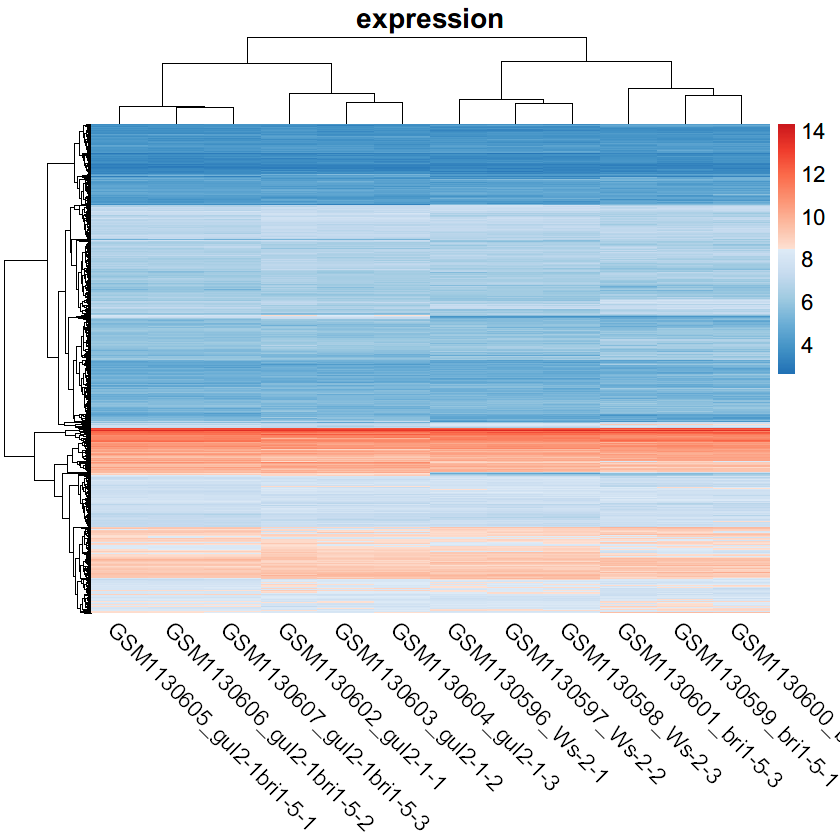

In [15]:
pheatmap(eset,
         col                = c(colorRampPalette(brewer.pal(9, "Blues")[7:2])(100),
                                colorRampPalette(brewer.pal(9, "Reds")[2:7])(100)),
         border_color       = NA,
         cluster_rows       = T,
         cluster_cols       = T,
         show_rownames      = F,
         show_colnames      = T,
         angle_col          = 315,
         fontsize           = 13,
         main               = "expression",
         display_numbers    = F)

DEG 火山图

Warning message:
"程辑包'ggpubr'是用R版本4.1.3 来建造的"

载入程辑包：'ggpubr'


The following object is masked from 'package:enrichplot':

    color_palette


Warning message:
"程辑包'ggthemes'是用R版本4.1.3 来建造的"



 down-regulated not-significant    up-regulated 
             13           11338              22 

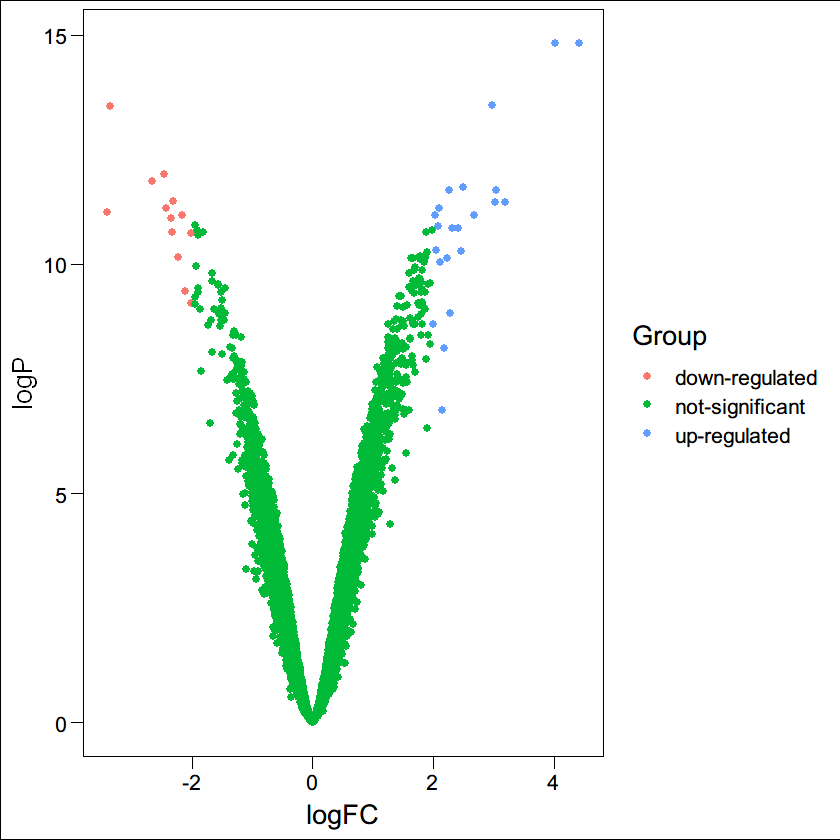

In [16]:
library(ggpubr)
library(ggthemes)
deg.data <- read.table("C:\\Users\\ZidongZh\\Documents\\BioInf\\GSE46456_RAW\\bri1.5_mutant-Wild_type.tsv", header = T, sep = "\t")
# - log10 值转换
deg.data$logP <- -log10(deg.data$adj.P.Val)
# 定义 Group 列
deg.data$Group <- "not-significant"
# 定义 DEG 标准
deg.data$Group[which ((deg.data$adj.P.Val < 0.05) & (deg.data$logFC > 2))] <- "up-regulated"
# 定义 DEG 标准
deg.data$Group[which ((deg.data$adj.P.Val < 0.05) & (deg.data$logFC < -2))] <- "down-regulated"
# 统计 DEG 数量
table(deg.data$Group)
ggscatter(deg.data, x = "logFC", y = "logP", color = "Group") + theme_base()

In [17]:
# 新加一列 lable
deg.data$Lable <- ""
# 对差异表达基因 P 值从小到大排序
deg.data <- deg.data[order(deg.data$adj.P.Val), ]
# 从高表达基因中选取 adj.P.Val 最显著的 10 个基因
up.genes <- head(deg.data$ID[which(deg.data$Group == "up-regulated")], 10)
# 从低表达基因中选取 adj.P.Val 最显著的 10 个基因
down.genes <- head(deg.data$ID[which(deg.data$Group == "down-regulated")], 10)
# 讲上两步选取的显著基因合并并加入到 lable 中
deg.top10.genes <- c(as.character(up.genes), as.character(down.genes))
deg.data$Lable[match(deg.top10.genes, deg.data$ID)] <- deg.top10.genes

Warning message:
"ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


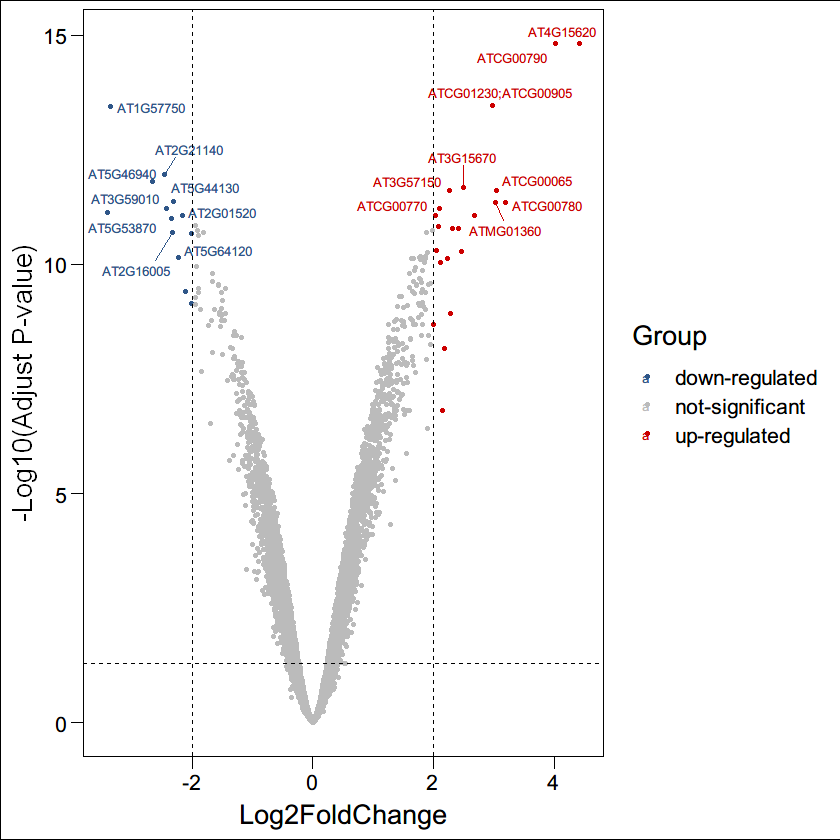

In [18]:
ggscatter(deg.data,
          x             = "logFC",
          y             = "logP",
          color         = "Group",
          palette       = c("#2f5688", "#BBBBBB", "#CC0000"),
          size          = 1,
          label         = deg.data$Lable,
          font.label    = 8,
          repel         = T,
          xlab          = "Log2FoldChange",
          ylab          = "-Log10(Adjust P-value)",) +
  theme_base() +
  geom_hline(yintercept = 1.30, linetype="dashed") +
  geom_vline(xintercept = c(-2,2),linetype="dashed")

输出 DEG 结果

In [21]:
write.table(deg.data, ".\\DEG_Plot_bri1.5mutant-Wild_type.tsv", sep = "\t")

3. 对所有基因做 GSEA 富集分析；并对三组上调的差异表达基因(`bri1-WT`, `gul2-WT`, `bri1_gul2-WT`)做 GO 富集分析，并解释富集结果，如有图片请注明图注信息。

富集分析 GSEA

In [40]:
# 导入 DEG 信息
data <- read.table(".\\DEG_Plot_bri1.5mutant-Wild_type.tsv", sep = "\t", header = TRUE)
GSEA_data <- data
# 提取表达量变化值
GSEA_gene_lists <- GSEA_data$logFC
# 给提取出来的值赋予 ID
names(GSEA_gene_lists) <- GSEA_data$ID
# 降序排列
GSEA_gene_lists <- sort(GSEA_gene_lists, decreasing = TRUE)
head(GSEA_gene_lists)

AT4G15620           ATCG00790           ATCG00780           ATCG00065 
           4.414308            4.022998            3.195997            3.039406 
          ATMG01360 ATCG01230;ATCG00905 
           3.020281            2.969045

preparing geneSet collections...

GSEA analysis...

Warning message in .GSEA(geneList = geneList, exponent = exponent, minGSSize = minGSSize, :
"We do not recommend using nPerm parameter incurrent and future releases"
Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
"You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."
leading edge analysis...

done...



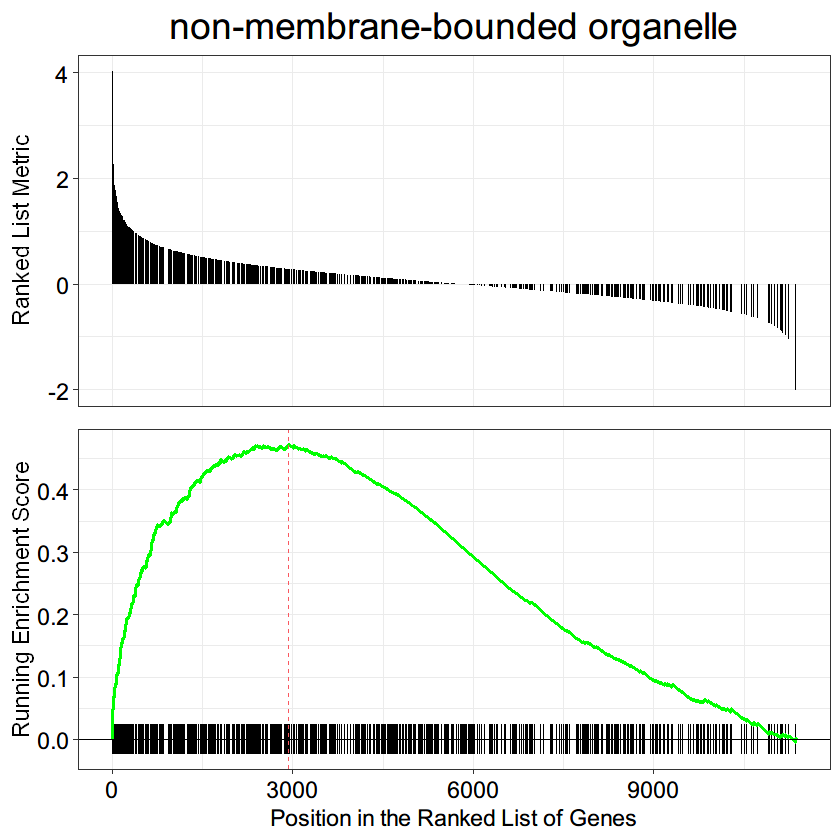

In [36]:
# 获取拟南芥数据库信息
organisms <- get("org.At.tair.db")
gse <- gseGO(geneList       = GSEA_gene_lists,
             ont            = "ALL",
             keyType        = "TAIR",
             nPerm          = 10000,
             minGSSize      = 3,
             maxGSSize      = 800,
             pvalueCutoff   = 0.05,
             verbose        = TRUE,
             OrgDb          = organisms,
             pAdjustMethod  = "none")
gseaplot(gse, by = "all", title = gse$Description[1], geneSetID = 1)

从总体上看，该基因集是上调趋势。

GO 富集分析

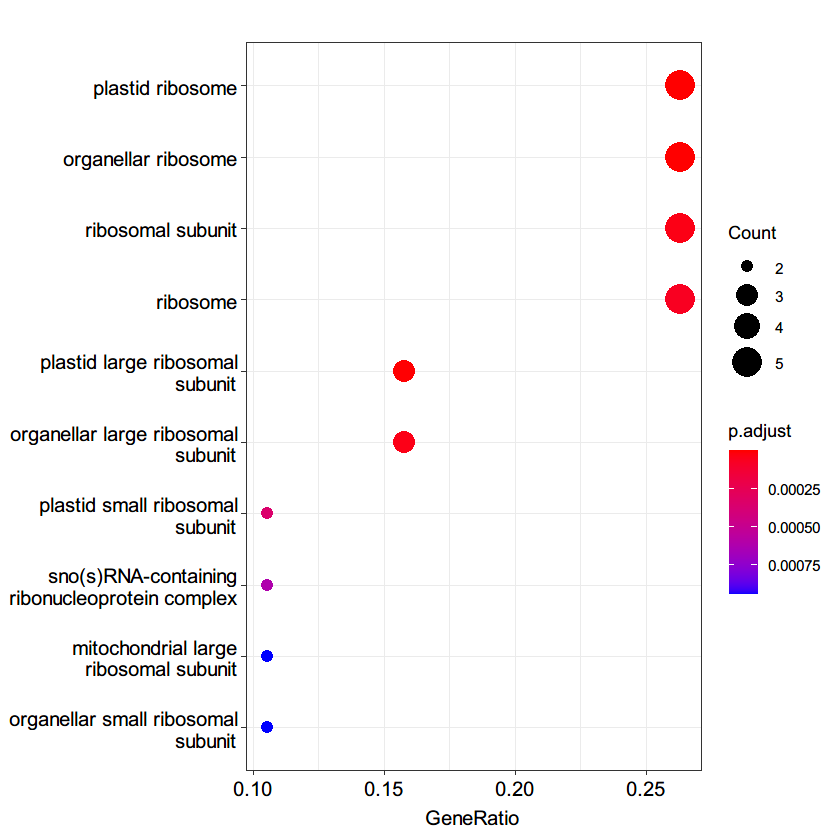

In [38]:
data<- data[data$Group == "up-regulated", ]
ego <- enrichGO(gene            = data$ID,
                keyType         = "TAIR",
                OrgDb           = organisms,
                ont             = "ALL",
                pAdjustMethod   = "BH",
                qvalueCutoff    = 0.05)
dotplot(ego, showCategory = 10)

## 讨论

在这次上机实验中，熟悉并掌握了分析芯片表达数据的流程，表达差异分析和基因辅基分析的方法，了解了常用的数据可视化方式。